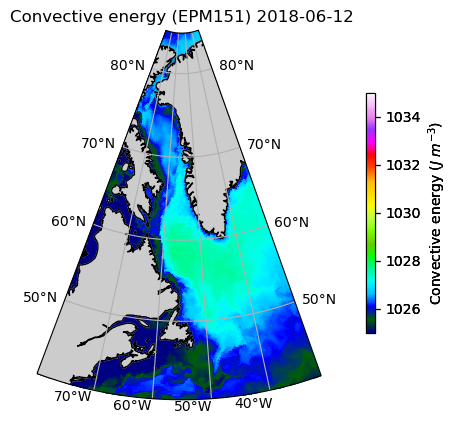

In [2]:
import xarray as xr
import os
import numpy as np
import density
import LSmap

outputFolder = '/mnt/storage6/myers/NEMO/ANHA4-EPM151/'
fileExtension = 'gridT.nc'
outputFiles = sorted([outputFolder + file for file in os.listdir(outputFolder) if file.endswith(fileExtension)])

grid = '/mnt/storage4/tahya/model_files/ANHA4_mesh_mask.nc'
with xr.open_dataset(grid) as DS:
    e1t = DS.e1t[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'}) 
    e2t = DS.e2t[0,:,:].rename({'y': 'y_grid_T','x': 'x_grid_T'})
    lons = np.array(DS.variables['nav_lon'])
    lats = np.array(DS.variables['nav_lat'])

preprocess_gridT = lambda ds: ds[['e3t','votemper','vosaline','somxl010']] #desired variables
with xr.open_mfdataset(outputFiles[0::600],preprocess=preprocess_gridT) as DS: #opens dataset
    T = DS.votemper
    S = DS.vosaline
    e3t = DS.e3t

deptht_index = 39
g = 9.80665

areas = np.multiply(e1t,e2t)
area = np.sum(areas)
h = DS.deptht[deptht_index]
Th = T[:,deptht_index,:,:]
Sh = S[:,deptht_index,:,:]

term1 = np.multiply(h,density.density(Sh,Th))
term2 = np.multiply(density.density(S[:,:deptht_index,:,:],T[:,:deptht_index,:,:]),e3t).sum(dim='deptht')
integrand = np.subtract(term1,term2)
convectiveEnergy = np.multiply((g/area),np.multiply(integrand,areas))

minmax = LSmap.xrLSminmax(density.density(S[:,0,:,:],T[:,0,:,:]), lats, lons)

CBlabel = 'Convective energy ($J$ $m^{-3}$)'
title = 'Convective energy (EPM151)'
fileName  = '../TestPics/LS_convective_energy_EPM151_'

minmax = 1025, 1035
LSmap.LSmap(density.density(S[:,0,:,:],T[:,0,:,:]),lons,lats,minmax,CBlabel,title,fileName)
